## 0. Imports Preliminaries

In [49]:
#!pip install nltk readability-lxml readability spacy keras==2.8

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
      --------------------------------------- 0.0/1.4 MB 660.6 kB/s eta 0:00:03
     - -------------------------------------- 0.0/1.4 MB 326.8 kB/s eta 0:00:05
     -- ------------------------------------- 0.1/1.4 MB 508.4 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/1.4 MB 508.4 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/1.4 MB 508.4 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/1.4 MB 508.4 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/1.4 MB 508.4 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/1.4 MB 201.8 kB/s eta 0:00:07
     --- ------------------------------------ 0.1/1.4 MB 233.8 kB/s eta 0:00:06
     --- ---------------------------

In [1]:
#0. Preliminaries
import pandas as pd
import nltk
nltk.download('punkt')
from readability import Readability

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import numpy as np
from sklearn.model_selection import train_test_split
import re
import spacy

In [8]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from transformers import pipeline
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student", max_length = 512, truncation = True)

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    tokenizer = tokenizer,
    return_all_scores=True
)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## 1. Load Data

In [26]:
#1. Import Data
df = pd.read_csv("../data/chunked_author_data_UTF8.csv")

In [4]:
len(df)

379

## 2. Clean Data 

In [14]:
def regex(string: str):
    """
    Function that applies regular expressions to a string based on the specified model.
    :param string: The input string.
    :param model: The model to determine which regular expressions to apply.
    :return: The modified string.
    """
    string = re.sub(r'e\.g\.', 'eg', string)  # replace e.g. with eg
    string = re.sub(r'i\.e\.', 'ie', string)  # replace i.e. with ie
    string = re.sub(r'-', ' ', string)  # replace - with space
    string = re.sub(r'[0-9]', '0', string)  # each digit will be represented as a 0
    string = re.sub(r'\(.*?\)', '', string) # remove parentheses and the text within
    string = re.sub(r'\[.*?\]', '', string) # remove brackets and the text within
    string = re.sub(r"https?:\/\/[a-zA-Z0-9.\/]+", "@", string) # remove links
    string = re.sub('[^A-Za-z0-9\s\.,\?!:;]+', '', string)# Remove special characters, so math formulas simplified.
    string = re.sub(r'\s\s+', ' ', string) # remove if there is more than 1 space, inlcuding new line \n and tab \t
    return string.strip() # Remove extra spaces at the begningining and end.

assert regex("a\t\n b") == "a b"
assert regex("q123") == "q000"
assert regex("a (something something) b (sth th)") == "a b"
assert regex("a [something something] b [sth12 th]") == "a b"
assert regex("2 + 5 % 2") == "0 0 0"
assert regex(",!;:.?") == ",!;:.?"

## 3. Add Features

In [15]:
#Flesch 
def flesch_readability_scale(text):
    try:
        r = Readability(text)
        f = r.flesch()
        score_out = f.score
    #not possible if less than 100 words
    except:
        score_out = np.nan
    return score_out

In [34]:
# Sentiment Analysis (Positive Score)
tokenizer_kwargs = {'truncation':True,'max_length':512}
def sentiment_analysis_score(text):
    results_senti = distilled_student_sentiment_classifier(text, **tokenizer_kwargs)
    positive_score = [x['score'] for x in results_senti[0] if x['label'] == 'positive']
    score_out = positive_score[0] if len(positive_score) == 1 else np.nan
    return score_out                          

In [35]:
def lexical_diversity(text):
    words = nltk.word_tokenize(text)
    return len(set(words)) / len(words)

assert lexical_diversity('a a b') == 2/3

In [36]:
from nltk.tokenize import sent_tokenize, word_tokenize

def avg_word_per_sentence(text):
    return np.mean([len(word_tokenize(sentence)) for sentence in sent_tokenize(text)])

assert avg_word_per_sentence('I like muffins. Please buy me two of them.') == 5.5

In [37]:
def avg_word_length(text):
    return np.mean([len(word) for sentence in sent_tokenize(text) for word in word_tokenize(sentence)])

assert avg_word_length('I like giant muffins. Please buy me two of them.') == 3.25

In [43]:
nlp = spacy.load("en_core_web_sm")

In [44]:
#remove proper nouns and POS-tag n grams
def POS_preprocessing(text):
    POS_string = ""
    cleaned_string = ""
    list_sentences = nltk.tokenize.sent_tokenize(text)
    for sentence in list_sentences:
        doc = nlp(sentence)
        for token in doc:
            #first add the text back
            string_out = "Propname" if token.pos_ == "PROPN" else token.text
            sep_out = "" if token.pos_ == "PUNCT" else " "
            cleaned_string = cleaned_string + sep_out + string_out
            #second 
            #POS_out = "" if token.pos_ == "PUNCT" else token.pos_
            POS_string = POS_string + " " + token.pos_
    return pd.Series({
        'cleaned_string': cleaned_string,
        'POS_string': POS_string
    })

In [42]:
def remove_bullet_points(text):
    bulletpoint_delimiters = re.compile(r'(\(i\)|\(ii\)|•)')
    text = re.sub(bulletpoint_delimiters, "", text)
    return text

In [27]:
df['flesch_score'] = df['Chunk'].apply(flesch_readability_scale)

In [28]:
average_score_author = df[['flesch_score', 'Author']].dropna().groupby('Author').mean().reset_index()
average_score_author.columns = ["Author", "mean_flesch"]
df = df.merge(average_score_author, how = "left", on = "Author")
df.loc[df['flesch_score'].isnull(), 'flesch_score'] = df.loc[df['flesch_score'].isnull(), 'mean_flesch']

In [61]:
df['sent_score'] = df['Chunk'].apply(sentiment_analysis_score)

In [64]:
df['re_text'] = df['Chunk'].apply(regex)
#train has to be run first - a catch statement for that
df['re_text'] = df['re_text'].apply(remove_bullet_points)
#removing double space should be after removing bullet points! leaves a double space sometimes
df[['re_text', 'POS_string']] = df['re_text'].apply(POS_preprocessing)
df['lexical_diversity'] = df['re_text'].apply(lexical_diversity)
df['avg_word_per_sentence'] = df['re_text'].apply(avg_word_per_sentence)
df['avg_word_length'] = df['re_text'].apply(avg_word_length)

In [66]:
df['re_text'][0]

' In the landscape of cloud based Propname Propname Propname, the array of sizes and configurations available presents a challenge in effectively balancing computational cost and performance optimization. This paper introduces Propname, an innovative approach designed to strategically route queries to larger LLMs based on the approximate correctness of outputs from a smaller Propname. At its core, Propname incorporates a few shot self verification mechanism, allowing it to estimate the reliability of its own outputs without the need for additional training. To address the inherent noise in verifications, Propname employs a meta verifier, enhancing the accuracy of these assessments. Experimental results using Propname Propname on five context grounded reasoning datasets illustrate that Propname outperforms established baselines, yielding an up to 00 improvement in the incremental benefit per cost.'

In [73]:
df.to_csv("../data/df_with_features.csv")

# 3. Split Data

In [74]:
def select_equal_groups(group: pd.core.groupby.generic.DataFrameGroupBy, n: int):

    return group.sample(min(n, len(group)), random_state=42)

share_train = 0.7
share_test = 0.3
samples_train = int(len(df)*(share_train*(1-share_test)))
samples_per_group = int(samples_train/5)

df['ID'] = range(0, len(df))
df_abstract_intro = df[~df['Type'].str.contains("conclusion_chunked")]
df_train= df_abstract_intro.groupby("Author", group_keys=False)\
        .apply(select_equal_groups, samples_per_group)\
        .reset_index(drop=True)

df_test_val = df[~df['ID'].isin(df_train['ID'])]
df_val = df_test_val[~df_test_val['Type'].str.contains("conclusion_chunked")]
df_val, df_test_0  = train_test_split(df_val, train_size = 0.5, stratify = df_val['Author'], random_state = 42)
df_test_1 = df_test_val[df_test_val['Type'].str.contains("conclusion_chunked")]
#df_test, df_val  = train_test_split(df_test_val, train_size = 0.5, stratify = df_test_val['Author'], random_state = 42)

In [75]:
df_train['Author'].value_counts()

Author
Aman Madaan     37
GPT-3.5         37
Hugo Touvron    37
Timo Schick     37
Zhiqing Sun     37
Name: count, dtype: int64

In [70]:
df_val['Author'].value_counts()

Author
Aman Madaan     13
Zhiqing Sun     12
Hugo Touvron    11
Timo Schick      9
GPT-3.5          6
Name: count, dtype: int64

In [72]:
df_test_0['Author'].value_counts()

Author
Zhiqing Sun     13
Aman Madaan     13
Hugo Touvron    11
Timo Schick     10
GPT-3.5          5
Name: count, dtype: int64

In [71]:
df_test_1['Author'].value_counts()

Author
GPT-3.5         24
Timo Schick     20
Aman Madaan     17
Hugo Touvron    15
Zhiqing Sun     15
Name: count, dtype: int64

In [89]:
#punctuation n-grams
punct_vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize, use_idf=False, norm='l1', vocabulary=string.punctuation)

In [90]:
pos_vectorizer = TfidfVectorizer(ngram_range=(2, 4))

In [91]:
stopword_vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=nltk.word_tokenize, vocabulary=stopwords.words("english"))

In [92]:
word_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

## 4. Tokenize Datasets

In [80]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
def clean_punct(test_str):
    for ele in test_str:
        if ele in punc:
            test_str = test_str.replace(ele, "")
    return test_str

In [87]:
def remove_stopwords(example_text):
    word_tokens = word_tokenize(example_text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stopwords.words("english")]
    return " ".join(filtered_sentence)

In [51]:
def preprocess_data(df, text_col, train = False):
    df = df.reset_index(drop = True)
    #these should be run first before cleaning punctuation and private words and stuff
    #df['flesch_score'] = df[text_col].apply(flesch_readability_scale)
    #commented out for now as takes long to run
    try:
        punct_features = punct_vectorizer.fit_transform(df[text_col]) if train else punct_vectorizer.transform(df[text_col])
        columns = [f'punct_{c}' for c in punct_vectorizer.get_feature_names_out()]
        punct_features_df = pd.DataFrame(punct_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, punct_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Punctuation N-grams: {e}")
    try:
        POS_features = pos_vectorizer.fit_transform(df['POS_string']) if train else pos_vectorizer.transform(df['POS_string'])
        columns = [f'pos_{c}' for c in pos_vectorizer.get_feature_names_out()]
        POS_features_df = pd.DataFrame(POS_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, POS_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating POS N-grams: {e}")

    #lowercase everything
    df[text_col] = df[text_col].apply(str.lower)
    df[text_col] = df[text_col].apply(clean_punct)

    try:
        stopwords_features = stopword_vectorizer.fit_transform(df[text_col]) if train else stopword_vectorizer.transform(df[text_col])
        columns = [f'stop_{c}' for c in stopword_vectorizer.get_feature_names_out()]
        stopwords_features_df = pd.DataFrame(stopwords_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, stopwords_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Stopword N-grams: {e}")

    #remove stopwords here
    df[text_col] = df[text_col].apply(remove_stopwords)
    try:
        words_features = word_vectorizer.fit_transform(df[text_col]) if train else word_vectorizer.transform(df[text_col])
        columns = [f'word_{c}' for c in word_vectorizer.get_feature_names_out()]
        words_features_df = pd.DataFrame(words_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, words_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Word N-grams: {e}")
    return df

In [93]:
df_train_processed = preprocess_data(df_train, 're_text', train = True)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [53]:
#df_train_processed.to_pickle("./df_train_processed.pkl")

In [94]:
df_val_processed = preprocess_data(df_val, 're_text', train = False)

In [95]:
df_test_0_processed = preprocess_data(df_test_0, 're_text', train = False)

In [96]:
df_test_1_processed = preprocess_data(df_test_1, 're_text', train = False)

In [57]:
# df_val_processed.to_pickle("./df_val_processed.pkl")
# df_test_0_processed.to_pickle("./df_test_0_processed.pkl")
# df_test_1_processed.to_pickle("./df_test_1_processed.pkl")

# 4. Run Models

In [97]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [142]:
X_train = df_train_processed.drop(columns = ["Author", "Chunk", "text", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "mean_flesch"])
colnames_reg = X_train.columns
y_train = df_train_processed['Author']
X_val = df_val_processed.drop(columns = ["Author", "Chunk", "text",  "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "mean_flesch"])
y_val = df_val_processed['Author']

In [143]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [99]:
def run_classifier(X_train, y_train, X_val, y_val, model):
    # Make predictions on the test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    # Evaluate the accuracy of the model
    return y_pred

In [107]:
#1. SVC
SVC_model = SVC(kernel = "linear")
predictions_SVC = run_classifier(X_train, y_train, X_val, y_val, SVC_model)

In [144]:
#2. RF
RF_model = RandomForestClassifier()
predictions_RF = run_classifier(X_train, y_train, X_val, y_val, RF_model)

In [145]:
forest_importances = pd.Series(RF_model.feature_importances_, index=colnames_reg)

In [146]:
forest_importances.sort_values(ascending=False).head(50)

flesch_score               0.005730
pos_noun punct verb        0.005629
pos_space noun             0.004334
word_it                    0.003929
pos_det space              0.003802
word_this                  0.003756
pos_noun verb              0.003546
stop_the                   0.003499
pos_adj noun adp verb      0.003352
word_paper                 0.003298
word_with                  0.003135
avg_word_length            0.003082
pos_punct verb             0.003065
lexical_diversity          0.003048
pos_adp verb               0.003026
pos_punct det adj          0.002953
word_no                    0.002767
word_reasoning             0.002747
sent_score                 0.002724
stop_this                  0.002705
punct_:                    0.002688
word_layers                0.002687
word_is                    0.002672
pos_noun punct pron        0.002645
pos_punct det              0.002621
pos_noun noun punct        0.002587
pos_verb det adj           0.002508
pos_noun propn             0

In [149]:
import eli5
from eli5 import show_prediction, show_weights

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\metaestimators.py)

In [28]:
len(np.where(y_val == predictions_SVC)[0])

40

In [30]:
clf = LogisticRegression(random_state=0)
predictions_LR = run_classifier(X_train, y_train, X_val, y_val, clf)

/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 5. Principal component analysis

/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/tmp/ipykernel_214465/2338430262.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names, rotation=90)
/tmp/ipykernel_214465/2338430262.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(feature_names))


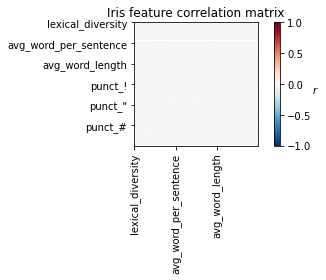

In [47]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
feature_names = X_train.columns.values.tolist()

X = StandardScaler().fit_transform(X_train)

ax = plt.axes()

im = ax.imshow(np.corrcoef(X.T), cmap="RdBu_r", vmin=-1, vmax=1)

#ax.set_xticks([0, 1, 2, 3])
#ax.set_xticklabels(feature_names, rotation=90)
#ax.set_yticks([0, 1, 2, 3])
#ax.set_yticklabels(list(feature_names))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Feature correlation matrix")
plt.tight_layout()


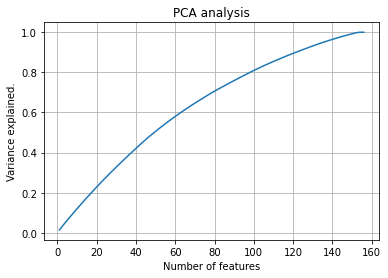

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


feature_names = X_train.columns.values.tolist()

pca = PCA(n_components=min(len(feature_names), len(X_train.index)))
pca.fit_transform(X)

fig, ax = plt.subplots()
var_explained = pca.explained_variance_ratio_.cumsum()
components = [i+1 for i in range(len(var_explained))]
ax.plot(components, var_explained)


ax.set(xlabel='Number of features', ylabel='Variance explained.',
       title='PCA analysis')
ax.grid()

fig.savefig("pca_analysis.png")
plt.show()
